In [1]:
import os
import csv
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import v2 as T
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix)
import seaborn as sns

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

Sử dụng thiết bị: cuda


In [3]:
class DynamicGraphAttention(nn.Module):
    def __init__(self, in_channels, num_nodes=32, heads=8, dropout=0.1):  # Tăng num_nodes/heads mặc định
        super().__init__()
        self.num_nodes = num_nodes
        self.heads = heads
        self.head_dim = in_channels // heads
        self.dropout = nn.Dropout(dropout)

        self.query = nn.Linear(in_channels, in_channels)
        self.key = nn.Linear(in_channels, in_channels)
        self.value = nn.Linear(in_channels, in_channels)
        self.out = nn.Linear(in_channels, in_channels)
        self.scale = nn.Parameter(torch.tensor(self.head_dim**-0.5))

        # Positional encoding (simple learnable)
        self.pos_enc = nn.Parameter(torch.randn(1, num_nodes, in_channels))

    def forward(self, x):
        B, C, H, W = x.size()
        x_flat = x.flatten(2).transpose(1, 2)  # (B, H*W, C)
        
        num_pixels = H * W
        N = min(self.num_nodes, num_pixels)
        
        # Importance sampling: Chọn top-k pixels dựa trên L2 norm (thay vì random/linspace)
        norms = torch.norm(x_flat, dim=-1)  # (B, H*W)
        _, indices = torch.topk(norms, N, dim=-1)  # Top-k indices
        indices = indices.sort(dim=-1).indices  # Sort để ổn định
        x_nodes = torch.gather(x_flat, 1, indices.unsqueeze(-1).expand(-1, -1, C))  # (B, N, C)
        
        # Thêm positional encoding
        x_nodes = x_nodes + self.pos_enc.expand(B, -1, -1)
        
        q = self.query(x_nodes).view(B, N, self.heads, self.head_dim).transpose(1, 2)
        k = self.key(x_nodes).view(B, N, self.heads, self.head_dim).transpose(1, 2)
        v = self.value(x_nodes).view(B, N, self.heads, self.head_dim).transpose(1, 2)
        
        attn_weights = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attn_weights = F.softmax(attn_weights, dim=-1)
        attn_weights = self.dropout(attn_weights)  # Thêm dropout
        attn_output = torch.matmul(attn_weights, v)
        attn_output = attn_output.transpose(1, 2).contiguous().view(B, N, C)
        
        out_nodes = self.out(attn_output)
        
        out_flat = torch.zeros_like(x_flat)
        out_flat.scatter_(1, indices.unsqueeze(-1).expand(-1, -1, C), out_nodes)
        out = out_flat.transpose(1, 2).view(B, C, H, W)
        
        return x + out  # Residual connection

class TemporalAttentionAggregator(nn.Module):
    def __init__(self, in_channels, num_heads=4):
        super().__init__()
        self.attention_net = nn.MultiheadAttention(embed_dim=in_channels, num_heads=num_heads)  # Thay MLP bằng MultiheadAttention
        self.norm = nn.LayerNorm(in_channels)

    def forward(self, x):
        if len(x.shape) == 4:  # (B, C, H, W) -> Giả sử single frame, flatten spatial
            B, C, H, W = x.size()
            x_flat = x.flatten(2).transpose(1, 2)  # (B, H*W, C)
        elif len(x.shape) == 5:  # (B, T, C, H, W) -> Flatten temporal-spatial
            B, T, C, H, W = x.size()
            x_flat = x.flatten(3).transpose(2, 3).reshape(B, T * H * W, C)  # (B, T*H*W, C)
        else:
            raise ValueError("Input must be 4D or 5D tensor")
        
        # Temporal-spatial attention
        x_flat = self.norm(x_flat)
        attn_output, _ = self.attention_net(x_flat, x_flat, x_flat)  # Self-attention
        
        # Aggregate
        aggregated_vector = torch.mean(attn_output, dim=1)  # Mean pooling thay sum để ổn định
        return aggregated_vector

class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expansion=6):  # Tăng expansion mặc định
        super().__init__()
        hidden_dim = in_channels * expansion
        self.use_residual = in_channels == out_channels and stride == 1
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.SiLU(inplace=True),  # Thay ReLU6 bằng SiLU (Swish)
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.SiLU(inplace=True),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )
        
        # Thêm SE block
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(out_channels, out_channels // 16, 1),
            nn.SiLU(),
            nn.Conv2d(out_channels // 16, out_channels, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.conv(x)
        out = out * self.se(out)  # Áp dụng SE
        return x + out if self.use_residual else out

In [4]:
class PestLarvaNet_Tiny(nn.Module):
    def __init__(self, num_classes, input_channels=1):
        super().__init__()
        self.config = [[1, 16, 1, 1], [4, 24, 2, 2], [4, 48, 2, 2]]
        self.stem = nn.Sequential(
            nn.Conv2d(input_channels, 16, 3, 2, 1, bias=False),
            nn.BatchNorm2d(16), nn.SiLU(inplace=True))
        
        layers = []
        in_channels = 16
        for t, c, n, s in self.config:
            for i in range(n):
                stride = s if i == 0 else 1
                layers.append(InvertedResidual(in_channels, c, stride, expansion=t))
                in_channels = c
        self.body = nn.Sequential(*layers)
        
        self.head_conv = nn.Conv2d(48, 128, 1, bias=False)
        self.aggregator = TemporalAttentionAggregator(128, num_heads=4)
        self.classifier = nn.Sequential(
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.stem(x); x = self.body(x); x = self.head_conv(x)
        x = self.aggregator(x); x = self.classifier(x); return x

In [5]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

In [6]:
class InsectSpectrogramDataset(Dataset):
    """Dataset tùy chỉnh để đọc các file spectrogram .pt"""
    def __init__(self, metadata_file, data_dir, transform=None):
        self.metadata = pd.read_csv(metadata_file)
        self.data_dir = data_dir
        self.transform = transform
        self.file_column = 'file_name'
        self.label_column = 'label'
        
        self.class_names = sorted(self.metadata[self.label_column].unique())
        self.class_to_id = {name: i for i, name in enumerate(self.class_names)}
        self.id_to_class = {i: name for name, i in self.class_to_id.items()}

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        file_name = self.metadata.iloc[idx][self.file_column]
        file_path = os.path.join(self.data_dir, file_name)
        label_name = self.metadata.iloc[idx][self.label_column]
        label = self.class_to_id[label_name]
        
        try:
            spectrogram = torch.load(file_path)
            if spectrogram.dim() == 2:
                spectrogram = spectrogram.unsqueeze(0)
            if self.transform:
                spectrogram = self.transform(spectrogram)
            return spectrogram, label
        except Exception as e:
            print(f"Lỗi khi tải file {file_path}: {e}")
            return torch.zeros(1, 128, 259), -1 # Trả về mẫu lỗi

In [7]:
METADATA_PATH = r'F:/metadata_Mel.csv' 
DATA_DIR = r'F:/MelSpectrograms'

In [8]:
class TimeShift(torch.nn.Module):
    """ Dịch chuyển spectrogram theo trục thời gian một cách ngẫu nhiên. """
    def __init__(self, p=0.5, max_shift_percent=0.4):
        super().__init__()
        self.p = p
        self.max_shift_percent = max_shift_percent

    def forward(self, spec):
        if torch.rand(1) < self.p:
            time_steps = spec.shape[-1]
            # Chọn một lượng dịch chuyển ngẫu nhiên
            shift_amount = int(torch.rand(1) * self.max_shift_percent * time_steps)
            # Dịch ngẫu nhiên sang trái hoặc phải
            if torch.rand(1) < 0.5:
                shift_amount = -shift_amount
            return torch.roll(spec, shifts=shift_amount, dims=-1)
        return spec

class SpecNoise(torch.nn.Module):
    """ Thêm nhiễu Gaussian trực tiếp vào spectrogram. """
    def __init__(self, p=0.5, noise_level=0.05):
        super().__init__()
        self.p = p
        self.noise_level = noise_level

    def forward(self, spec):
        if torch.rand(1) < self.p:
            noise = torch.randn_like(spec) * self.noise_level
            return spec + noise
        return spec

In [9]:
train_transform = T.Compose([
    # Kỹ thuật 1: SpecAugment (Time & Frequency Masking)
    torchaudio.transforms.TimeMasking(time_mask_param=80),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=25),
    
    # Kỹ thuật 2: Time Shifting
    TimeShift(p=0.5, max_shift_percent=0.4),
    
    # Kỹ thuật 3: Spectrogram Noise
    SpecNoise(p=0.3, noise_level=0.03),
])

# Tập validation không sử dụng augmentation
val_transform = None

print("Đã định nghĩa xong pipeline Augmentation cho Spectrogram.")

Đã định nghĩa xong pipeline Augmentation cho Spectrogram.


In [10]:
def mixup_data(x, y, alpha=0.4, use_cuda=True):
    """
    Trộn dữ liệu trong một batch.
    Trả về input đã trộn, và hai bộ nhãn gốc cùng với hệ số trộn lambda.
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """
    Hàm tính loss đặc biệt cho Mixup.
    """
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [11]:
if not os.path.exists(METADATA_PATH) or not os.path.isdir(DATA_DIR):
    print("!!! LỖI: Vui lòng kiểm tra lại đường dẫn METADATA_PATH và DATA_DIR.")
else:
    full_dataset = InsectSpectrogramDataset(METADATA_PATH, DATA_DIR)
    num_classes = len(full_dataset.class_names)
    print(f"Tải dữ liệu thành công: {len(full_dataset)} mẫu, {num_classes} lớp.")

    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    generator = torch.Generator().manual_seed(42)
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator)

    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = val_transform

    BATCH_SIZE = 32
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Tải dữ liệu thành công: 165982 mẫu, 12 lớp.


In [12]:
EPOCHS = 100
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4

CHECKPOINT_DIR = r'F:/checkpoints_tiny'
LOG_CSV_PATH = 'F:/training_log_tiny.csv'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [13]:
model = PestLarvaNet_Tiny(num_classes=num_classes).to(device)
total_params, _ = count_parameters(model)
print(f"Khởi tạo mô hình PestLarvaNet-GMA với {total_params/1e6:.2f}M tham số.")

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

Khởi tạo mô hình PestLarvaNet-GMA với 0.11M tham số.


In [14]:
log_header = [
    'epoch', 'train_loss', 'val_loss', 'learning_rate', 'accuracy',
    'macro_f1', 'weighted_f1', 
    'precision_micro', # Thay thế 'macro_precision', 'weighted_precision'
    'recall_micro'     # Thay thế 'macro_recall', 'weighted_recall'
]
# --- KẾT THÚC THAY ĐỔI ---

with open(LOG_CSV_PATH, 'w', newline='', encoding='utf-8') as f:
    csv.writer(f).writerow(log_header)

print(f"\nBắt đầu huấn luyện... Checkpoints sẽ được lưu tại '{CHECKPOINT_DIR}' và log tại '{LOG_CSV_PATH}'")

# --- Vòng lặp huấn luyện chính ---
best_val_f1 = 0.0


Bắt đầu huấn luyện... Checkpoints sẽ được lưu tại 'F:/checkpoints_tiny' và log tại 'F:/training_log_tiny.csv'


In [15]:
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]")
    
    for inputs, labels in progress_bar:
        if -1 in labels: continue # Bỏ qua các mẫu bị lỗi
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Áp dụng Mixup với xác suất 50%
        if torch.rand(1).item() < 0.5:
            inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=0.4)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        else:
            # Chạy như bình thường nếu không dùng Mixup
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")


    model.eval()
    val_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Validation]"):
            if -1 in labels: continue
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            
    epoch_train_loss = running_loss / len(train_dataset)
    epoch_val_loss = val_loss / len(val_dataset)
    
    # --- THAY ĐỔI Ở ĐÂY ---
    # Giữ nguyên F1-score với 2 phiên bản
    accuracy = accuracy_score(val_labels, val_preds)
    macro_f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)
    weighted_f1 = f1_score(val_labels, val_preds, average='weighted', zero_division=0)
    
    # Tính Precision và Recall phiên bản tổng thể (micro)
    precision = precision_score(val_labels, val_preds, average='micro', zero_division=0)
    recall = recall_score(val_labels, val_preds, average='micro', zero_division=0)
    # --- KẾT THÚC THAY ĐỔI ---
    
    current_lr = scheduler.get_last_lr()[0]
    scheduler.step()

    # In kết quả ra màn hình
    print(f"\n--- Epoch {epoch+1}/{EPOCHS} Summary ---")
    print(f"  Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    print(f"  Accuracy: {accuracy:.4f} | Weighted F1: {weighted_f1:.4f}")
    # Thêm dòng in cho Precision và Recall tổng thể
    print(f"  Precision (Micro): {precision:.4f} | Recall (Micro): {recall:.4f}") 
    print(f"  Learning Rate: {current_lr:.6f}")

    # --- THAY ĐỔI Ở ĐÂY ---
    # Lưu vào file CSV
    log_data = [
        epoch + 1, epoch_train_loss, epoch_val_loss, current_lr, accuracy,
        macro_f1, weighted_f1, 
        precision, # Thay thế các phiên bản macro/weighted
        recall     # Thay thế các phiên bản macro/weighted
    ]
    # --- KẾT THÚC THAY ĐỔI ---

    with open(LOG_CSV_PATH, 'a', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(log_data)
        
    # Lưu Checkpoint mỗi epoch
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_epoch_{epoch+1}.pth')
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, checkpoint_path)

    # Lưu lại model tốt nhất (dựa trên weighted F1-score)
    if weighted_f1 > best_val_f1:
        best_val_f1 = weighted_f1
        best_model_path = os.path.join(CHECKPOINT_DIR, 'best_model.pth')
        torch.save(model.state_dict(), best_model_path)
        print(f"  => 🎉 New best model saved to '{best_model_path}' (Weighted F1: {best_val_f1:.4f})\n")

print("\n✅ Hoàn tất huấn luyện!")

Epoch 1/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 1/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 1/100 Summary ---
  Train Loss: 1.2540 | Val Loss: 0.9510
  Accuracy: 0.6662 | Weighted F1: 0.6372
  Precision (Micro): 0.6662 | Recall (Micro): 0.6662
  Learning Rate: 0.001000
  => 🎉 New best model saved to 'F:/checkpoints_tiny\best_model.pth' (Weighted F1: 0.6372)



Epoch 2/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 2/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 2/100 Summary ---
  Train Loss: 1.0017 | Val Loss: 0.8587
  Accuracy: 0.7029 | Weighted F1: 0.6875
  Precision (Micro): 0.7029 | Recall (Micro): 0.7029
  Learning Rate: 0.001000
  => 🎉 New best model saved to 'F:/checkpoints_tiny\best_model.pth' (Weighted F1: 0.6875)



Epoch 3/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 3/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 3/100 Summary ---
  Train Loss: 0.9208 | Val Loss: 0.8212
  Accuracy: 0.7049 | Weighted F1: 0.7081
  Precision (Micro): 0.7049 | Recall (Micro): 0.7049
  Learning Rate: 0.000999
  => 🎉 New best model saved to 'F:/checkpoints_tiny\best_model.pth' (Weighted F1: 0.7081)



Epoch 4/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 4/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 4/100 Summary ---
  Train Loss: 0.8711 | Val Loss: 0.5765
  Accuracy: 0.7950 | Weighted F1: 0.7920
  Precision (Micro): 0.7950 | Recall (Micro): 0.7950
  Learning Rate: 0.000998
  => 🎉 New best model saved to 'F:/checkpoints_tiny\best_model.pth' (Weighted F1: 0.7920)



Epoch 5/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 5/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 5/100 Summary ---
  Train Loss: 0.8127 | Val Loss: 0.7459
  Accuracy: 0.7359 | Weighted F1: 0.7280
  Precision (Micro): 0.7359 | Recall (Micro): 0.7359
  Learning Rate: 0.000996


Epoch 6/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 6/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 6/100 Summary ---
  Train Loss: 0.7785 | Val Loss: 0.7297
  Accuracy: 0.7437 | Weighted F1: 0.7467
  Precision (Micro): 0.7437 | Recall (Micro): 0.7437
  Learning Rate: 0.000994


Epoch 7/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 7/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 7/100 Summary ---
  Train Loss: 0.7557 | Val Loss: 0.5929
  Accuracy: 0.7911 | Weighted F1: 0.7893
  Precision (Micro): 0.7911 | Recall (Micro): 0.7911
  Learning Rate: 0.000991


Epoch 8/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 8/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 8/100 Summary ---
  Train Loss: 0.7203 | Val Loss: 0.5073
  Accuracy: 0.8154 | Weighted F1: 0.8158
  Precision (Micro): 0.8154 | Recall (Micro): 0.8154
  Learning Rate: 0.000988
  => 🎉 New best model saved to 'F:/checkpoints_tiny\best_model.pth' (Weighted F1: 0.8158)



Epoch 9/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 9/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 9/100 Summary ---
  Train Loss: 0.7097 | Val Loss: 0.6005
  Accuracy: 0.7906 | Weighted F1: 0.7911
  Precision (Micro): 0.7906 | Recall (Micro): 0.7906
  Learning Rate: 0.000984


Epoch 10/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 10/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 10/100 Summary ---
  Train Loss: 0.6865 | Val Loss: 0.4884
  Accuracy: 0.8347 | Weighted F1: 0.8315
  Precision (Micro): 0.8347 | Recall (Micro): 0.8347
  Learning Rate: 0.000980
  => 🎉 New best model saved to 'F:/checkpoints_tiny\best_model.pth' (Weighted F1: 0.8315)



Epoch 11/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 11/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 11/100 Summary ---
  Train Loss: 0.6697 | Val Loss: 0.4370
  Accuracy: 0.8448 | Weighted F1: 0.8432
  Precision (Micro): 0.8448 | Recall (Micro): 0.8448
  Learning Rate: 0.000976
  => 🎉 New best model saved to 'F:/checkpoints_tiny\best_model.pth' (Weighted F1: 0.8432)



Epoch 12/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 12/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 12/100 Summary ---
  Train Loss: 0.6694 | Val Loss: 0.4573
  Accuracy: 0.8402 | Weighted F1: 0.8366
  Precision (Micro): 0.8402 | Recall (Micro): 0.8402
  Learning Rate: 0.000970


Epoch 13/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 13/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 13/100 Summary ---
  Train Loss: 0.6515 | Val Loss: 0.4470
  Accuracy: 0.8391 | Weighted F1: 0.8419
  Precision (Micro): 0.8391 | Recall (Micro): 0.8391
  Learning Rate: 0.000965


Epoch 14/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 14/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 14/100 Summary ---
  Train Loss: 0.6437 | Val Loss: 0.4406
  Accuracy: 0.8505 | Weighted F1: 0.8485
  Precision (Micro): 0.8505 | Recall (Micro): 0.8505
  Learning Rate: 0.000959
  => 🎉 New best model saved to 'F:/checkpoints_tiny\best_model.pth' (Weighted F1: 0.8485)



Epoch 15/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 15/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 15/100 Summary ---
  Train Loss: 0.6318 | Val Loss: 0.3703
  Accuracy: 0.8708 | Weighted F1: 0.8693
  Precision (Micro): 0.8708 | Recall (Micro): 0.8708
  Learning Rate: 0.000952
  => 🎉 New best model saved to 'F:/checkpoints_tiny\best_model.pth' (Weighted F1: 0.8693)



Epoch 16/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 16/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 16/100 Summary ---
  Train Loss: 0.6197 | Val Loss: 0.6068
  Accuracy: 0.7944 | Weighted F1: 0.7871
  Precision (Micro): 0.7944 | Recall (Micro): 0.7944
  Learning Rate: 0.000946


Epoch 17/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 17/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 17/100 Summary ---
  Train Loss: 0.6053 | Val Loss: 0.3589
  Accuracy: 0.8745 | Weighted F1: 0.8738
  Precision (Micro): 0.8745 | Recall (Micro): 0.8745
  Learning Rate: 0.000938
  => 🎉 New best model saved to 'F:/checkpoints_tiny\best_model.pth' (Weighted F1: 0.8738)



Epoch 18/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 18/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 18/100 Summary ---
  Train Loss: 0.5978 | Val Loss: 0.4095
  Accuracy: 0.8576 | Weighted F1: 0.8552
  Precision (Micro): 0.8576 | Recall (Micro): 0.8576
  Learning Rate: 0.000930


Epoch 19/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 19/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 19/100 Summary ---
  Train Loss: 0.5974 | Val Loss: 0.4234
  Accuracy: 0.8543 | Weighted F1: 0.8556
  Precision (Micro): 0.8543 | Recall (Micro): 0.8543
  Learning Rate: 0.000922


Epoch 20/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 20/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 20/100 Summary ---
  Train Loss: 0.5891 | Val Loss: 0.5273
  Accuracy: 0.8191 | Weighted F1: 0.8165
  Precision (Micro): 0.8191 | Recall (Micro): 0.8191
  Learning Rate: 0.000914


Epoch 21/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 21/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 21/100 Summary ---
  Train Loss: 0.6006 | Val Loss: 0.4423
  Accuracy: 0.8479 | Weighted F1: 0.8463
  Precision (Micro): 0.8479 | Recall (Micro): 0.8479
  Learning Rate: 0.000905


Epoch 22/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 22/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 22/100 Summary ---
  Train Loss: 0.5746 | Val Loss: 0.4013
  Accuracy: 0.8578 | Weighted F1: 0.8586
  Precision (Micro): 0.8578 | Recall (Micro): 0.8578
  Learning Rate: 0.000895


Epoch 23/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 23/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 23/100 Summary ---
  Train Loss: 0.5678 | Val Loss: 0.4604
  Accuracy: 0.8380 | Weighted F1: 0.8360
  Precision (Micro): 0.8380 | Recall (Micro): 0.8380
  Learning Rate: 0.000885


Epoch 24/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 24/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 24/100 Summary ---
  Train Loss: 0.5704 | Val Loss: 0.3877
  Accuracy: 0.8651 | Weighted F1: 0.8635
  Precision (Micro): 0.8651 | Recall (Micro): 0.8651
  Learning Rate: 0.000875


Epoch 25/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 25/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 25/100 Summary ---
  Train Loss: 0.5630 | Val Loss: 0.3278
  Accuracy: 0.8850 | Weighted F1: 0.8846
  Precision (Micro): 0.8850 | Recall (Micro): 0.8850
  Learning Rate: 0.000864
  => 🎉 New best model saved to 'F:/checkpoints_tiny\best_model.pth' (Weighted F1: 0.8846)



Epoch 26/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 26/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 26/100 Summary ---
  Train Loss: 0.5638 | Val Loss: 0.3579
  Accuracy: 0.8813 | Weighted F1: 0.8810
  Precision (Micro): 0.8813 | Recall (Micro): 0.8813
  Learning Rate: 0.000854


Epoch 27/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 27/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 27/100 Summary ---
  Train Loss: 0.5546 | Val Loss: 0.3297
  Accuracy: 0.8835 | Weighted F1: 0.8832
  Precision (Micro): 0.8835 | Recall (Micro): 0.8835
  Learning Rate: 0.000842


Epoch 28/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 28/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 28/100 Summary ---
  Train Loss: 0.5489 | Val Loss: 0.4816
  Accuracy: 0.8340 | Weighted F1: 0.8341
  Precision (Micro): 0.8340 | Recall (Micro): 0.8340
  Learning Rate: 0.000831


Epoch 29/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 29/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 29/100 Summary ---
  Train Loss: 0.5601 | Val Loss: 0.4467
  Accuracy: 0.8474 | Weighted F1: 0.8422
  Precision (Micro): 0.8474 | Recall (Micro): 0.8474
  Learning Rate: 0.000819


Epoch 30/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 30/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 30/100 Summary ---
  Train Loss: 0.5484 | Val Loss: 0.3184
  Accuracy: 0.8909 | Weighted F1: 0.8906
  Precision (Micro): 0.8909 | Recall (Micro): 0.8909
  Learning Rate: 0.000806
  => 🎉 New best model saved to 'F:/checkpoints_tiny\best_model.pth' (Weighted F1: 0.8906)



Epoch 31/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 31/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 31/100 Summary ---
  Train Loss: 0.5481 | Val Loss: 0.3447
  Accuracy: 0.8845 | Weighted F1: 0.8844
  Precision (Micro): 0.8845 | Recall (Micro): 0.8845
  Learning Rate: 0.000794


Epoch 32/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 32/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 32/100 Summary ---
  Train Loss: 0.5353 | Val Loss: 0.4880
  Accuracy: 0.8352 | Weighted F1: 0.8379
  Precision (Micro): 0.8352 | Recall (Micro): 0.8352
  Learning Rate: 0.000781


Epoch 33/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 33/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 33/100 Summary ---
  Train Loss: 0.5226 | Val Loss: 0.4375
  Accuracy: 0.8493 | Weighted F1: 0.8463
  Precision (Micro): 0.8493 | Recall (Micro): 0.8493
  Learning Rate: 0.000768


Epoch 34/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 34/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 34/100 Summary ---
  Train Loss: 0.5366 | Val Loss: 0.3376
  Accuracy: 0.8812 | Weighted F1: 0.8821
  Precision (Micro): 0.8812 | Recall (Micro): 0.8812
  Learning Rate: 0.000755


Epoch 35/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 35/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 35/100 Summary ---
  Train Loss: 0.5258 | Val Loss: 0.3253
  Accuracy: 0.8860 | Weighted F1: 0.8845
  Precision (Micro): 0.8860 | Recall (Micro): 0.8860
  Learning Rate: 0.000741


Epoch 36/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 36/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 36/100 Summary ---
  Train Loss: 0.5282 | Val Loss: 0.3144
  Accuracy: 0.8916 | Weighted F1: 0.8917
  Precision (Micro): 0.8916 | Recall (Micro): 0.8916
  Learning Rate: 0.000727
  => 🎉 New best model saved to 'F:/checkpoints_tiny\best_model.pth' (Weighted F1: 0.8917)



Epoch 37/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 37/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 37/100 Summary ---
  Train Loss: 0.5204 | Val Loss: 0.4054
  Accuracy: 0.8600 | Weighted F1: 0.8583
  Precision (Micro): 0.8600 | Recall (Micro): 0.8600
  Learning Rate: 0.000713


Epoch 38/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 38/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 38/100 Summary ---
  Train Loss: 0.5222 | Val Loss: 0.3178
  Accuracy: 0.8916 | Weighted F1: 0.8914
  Precision (Micro): 0.8916 | Recall (Micro): 0.8916
  Learning Rate: 0.000699


Epoch 39/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 39/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 39/100 Summary ---
  Train Loss: 0.5152 | Val Loss: 0.3536
  Accuracy: 0.8788 | Weighted F1: 0.8764
  Precision (Micro): 0.8788 | Recall (Micro): 0.8788
  Learning Rate: 0.000684


Epoch 40/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 40/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 40/100 Summary ---
  Train Loss: 0.5126 | Val Loss: 0.3570
  Accuracy: 0.8770 | Weighted F1: 0.8774
  Precision (Micro): 0.8770 | Recall (Micro): 0.8770
  Learning Rate: 0.000669


Epoch 41/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 41/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 41/100 Summary ---
  Train Loss: 0.5049 | Val Loss: 0.3304
  Accuracy: 0.8865 | Weighted F1: 0.8852
  Precision (Micro): 0.8865 | Recall (Micro): 0.8865
  Learning Rate: 0.000655


Epoch 42/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 42/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 42/100 Summary ---
  Train Loss: 0.5033 | Val Loss: 0.3419
  Accuracy: 0.8835 | Weighted F1: 0.8826
  Precision (Micro): 0.8835 | Recall (Micro): 0.8835
  Learning Rate: 0.000639


Epoch 43/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 43/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 43/100 Summary ---
  Train Loss: 0.5064 | Val Loss: 0.3172
  Accuracy: 0.8936 | Weighted F1: 0.8932
  Precision (Micro): 0.8936 | Recall (Micro): 0.8936
  Learning Rate: 0.000624
  => 🎉 New best model saved to 'F:/checkpoints_tiny\best_model.pth' (Weighted F1: 0.8932)



Epoch 44/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 44/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 44/100 Summary ---
  Train Loss: 0.4967 | Val Loss: 0.3333
  Accuracy: 0.8854 | Weighted F1: 0.8859
  Precision (Micro): 0.8854 | Recall (Micro): 0.8854
  Learning Rate: 0.000609


Epoch 45/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 45/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 45/100 Summary ---
  Train Loss: 0.5087 | Val Loss: 0.3132
  Accuracy: 0.8917 | Weighted F1: 0.8907
  Precision (Micro): 0.8917 | Recall (Micro): 0.8917
  Learning Rate: 0.000594


Epoch 46/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 46/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 46/100 Summary ---
  Train Loss: 0.5083 | Val Loss: 0.3014
  Accuracy: 0.8968 | Weighted F1: 0.8963
  Precision (Micro): 0.8968 | Recall (Micro): 0.8968
  Learning Rate: 0.000578
  => 🎉 New best model saved to 'F:/checkpoints_tiny\best_model.pth' (Weighted F1: 0.8963)



Epoch 47/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 47/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 47/100 Summary ---
  Train Loss: 0.4897 | Val Loss: 0.3276
  Accuracy: 0.8896 | Weighted F1: 0.8892
  Precision (Micro): 0.8896 | Recall (Micro): 0.8896
  Learning Rate: 0.000563


Epoch 48/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 48/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 48/100 Summary ---
  Train Loss: 0.4869 | Val Loss: 0.3131
  Accuracy: 0.8926 | Weighted F1: 0.8933
  Precision (Micro): 0.8926 | Recall (Micro): 0.8926
  Learning Rate: 0.000547


Epoch 49/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 49/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 49/100 Summary ---
  Train Loss: 0.4873 | Val Loss: 0.2874
  Accuracy: 0.9004 | Weighted F1: 0.9002
  Precision (Micro): 0.9004 | Recall (Micro): 0.9004
  Learning Rate: 0.000531
  => 🎉 New best model saved to 'F:/checkpoints_tiny\best_model.pth' (Weighted F1: 0.9002)



Epoch 50/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 50/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 50/100 Summary ---
  Train Loss: 0.4820 | Val Loss: 0.3330
  Accuracy: 0.8878 | Weighted F1: 0.8880
  Precision (Micro): 0.8878 | Recall (Micro): 0.8878
  Learning Rate: 0.000516


Epoch 51/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 51/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 51/100 Summary ---
  Train Loss: 0.4942 | Val Loss: 0.2993
  Accuracy: 0.8965 | Weighted F1: 0.8966
  Precision (Micro): 0.8965 | Recall (Micro): 0.8965
  Learning Rate: 0.000500


Epoch 52/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 52/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 52/100 Summary ---
  Train Loss: 0.4913 | Val Loss: 0.3203
  Accuracy: 0.8901 | Weighted F1: 0.8892
  Precision (Micro): 0.8901 | Recall (Micro): 0.8901
  Learning Rate: 0.000484


Epoch 53/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 53/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 53/100 Summary ---
  Train Loss: 0.4802 | Val Loss: 0.3137
  Accuracy: 0.8935 | Weighted F1: 0.8933
  Precision (Micro): 0.8935 | Recall (Micro): 0.8935
  Learning Rate: 0.000469


Epoch 54/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 54/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 54/100 Summary ---
  Train Loss: 0.4797 | Val Loss: 0.2797
  Accuracy: 0.9034 | Weighted F1: 0.9031
  Precision (Micro): 0.9034 | Recall (Micro): 0.9034
  Learning Rate: 0.000453
  => 🎉 New best model saved to 'F:/checkpoints_tiny\best_model.pth' (Weighted F1: 0.9031)



Epoch 55/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 55/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 55/100 Summary ---
  Train Loss: 0.4802 | Val Loss: 0.3257
  Accuracy: 0.8920 | Weighted F1: 0.8905
  Precision (Micro): 0.8920 | Recall (Micro): 0.8920
  Learning Rate: 0.000437


Epoch 56/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 56/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 56/100 Summary ---
  Train Loss: 0.4776 | Val Loss: 0.3371
  Accuracy: 0.8882 | Weighted F1: 0.8883
  Precision (Micro): 0.8882 | Recall (Micro): 0.8882
  Learning Rate: 0.000422


Epoch 57/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 57/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 57/100 Summary ---
  Train Loss: 0.4687 | Val Loss: 0.3062
  Accuracy: 0.8989 | Weighted F1: 0.8986
  Precision (Micro): 0.8989 | Recall (Micro): 0.8989
  Learning Rate: 0.000406


Epoch 58/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 58/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 58/100 Summary ---
  Train Loss: 0.4684 | Val Loss: 0.3161
  Accuracy: 0.8966 | Weighted F1: 0.8961
  Precision (Micro): 0.8966 | Recall (Micro): 0.8966
  Learning Rate: 0.000391


Epoch 59/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 59/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 59/100 Summary ---
  Train Loss: 0.4704 | Val Loss: 0.3095
  Accuracy: 0.8979 | Weighted F1: 0.8978
  Precision (Micro): 0.8979 | Recall (Micro): 0.8979
  Learning Rate: 0.000376


Epoch 60/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 60/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 60/100 Summary ---
  Train Loss: 0.4765 | Val Loss: 0.2932
  Accuracy: 0.9009 | Weighted F1: 0.9011
  Precision (Micro): 0.9009 | Recall (Micro): 0.9009
  Learning Rate: 0.000361


Epoch 61/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 61/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 61/100 Summary ---
  Train Loss: 0.4554 | Val Loss: 0.3575
  Accuracy: 0.8855 | Weighted F1: 0.8850
  Precision (Micro): 0.8855 | Recall (Micro): 0.8855
  Learning Rate: 0.000345


Epoch 62/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 62/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 62/100 Summary ---
  Train Loss: 0.4661 | Val Loss: 0.3229
  Accuracy: 0.8932 | Weighted F1: 0.8920
  Precision (Micro): 0.8932 | Recall (Micro): 0.8932
  Learning Rate: 0.000331


Epoch 63/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 63/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 63/100 Summary ---
  Train Loss: 0.4618 | Val Loss: 0.2957
  Accuracy: 0.8992 | Weighted F1: 0.8984
  Precision (Micro): 0.8992 | Recall (Micro): 0.8992
  Learning Rate: 0.000316


Epoch 64/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 64/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 64/100 Summary ---
  Train Loss: 0.4527 | Val Loss: 0.2813
  Accuracy: 0.9042 | Weighted F1: 0.9037
  Precision (Micro): 0.9042 | Recall (Micro): 0.9042
  Learning Rate: 0.000301
  => 🎉 New best model saved to 'F:/checkpoints_tiny\best_model.pth' (Weighted F1: 0.9037)



Epoch 65/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 65/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 65/100 Summary ---
  Train Loss: 0.4524 | Val Loss: 0.2875
  Accuracy: 0.9021 | Weighted F1: 0.9026
  Precision (Micro): 0.9021 | Recall (Micro): 0.9021
  Learning Rate: 0.000287


Epoch 66/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 66/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 66/100 Summary ---
  Train Loss: 0.4505 | Val Loss: 0.2882
  Accuracy: 0.9010 | Weighted F1: 0.9008
  Precision (Micro): 0.9010 | Recall (Micro): 0.9010
  Learning Rate: 0.000273


Epoch 67/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 67/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 67/100 Summary ---
  Train Loss: 0.4463 | Val Loss: 0.2910
  Accuracy: 0.9007 | Weighted F1: 0.9006
  Precision (Micro): 0.9007 | Recall (Micro): 0.9007
  Learning Rate: 0.000259


Epoch 68/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 68/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 68/100 Summary ---
  Train Loss: 0.4465 | Val Loss: 0.2793
  Accuracy: 0.9026 | Weighted F1: 0.9024
  Precision (Micro): 0.9026 | Recall (Micro): 0.9026
  Learning Rate: 0.000245


Epoch 69/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 69/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 69/100 Summary ---
  Train Loss: 0.4460 | Val Loss: 0.2797
  Accuracy: 0.9043 | Weighted F1: 0.9041
  Precision (Micro): 0.9043 | Recall (Micro): 0.9043
  Learning Rate: 0.000232
  => 🎉 New best model saved to 'F:/checkpoints_tiny\best_model.pth' (Weighted F1: 0.9041)



Epoch 70/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 70/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 70/100 Summary ---
  Train Loss: 0.4505 | Val Loss: 0.2865
  Accuracy: 0.9013 | Weighted F1: 0.9014
  Precision (Micro): 0.9013 | Recall (Micro): 0.9013
  Learning Rate: 0.000219


Epoch 71/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 71/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 71/100 Summary ---
  Train Loss: 0.4474 | Val Loss: 0.2933
  Accuracy: 0.8996 | Weighted F1: 0.8995
  Precision (Micro): 0.8996 | Recall (Micro): 0.8996
  Learning Rate: 0.000206


Epoch 72/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 72/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 72/100 Summary ---
  Train Loss: 0.4312 | Val Loss: 0.2802
  Accuracy: 0.9031 | Weighted F1: 0.9030
  Precision (Micro): 0.9031 | Recall (Micro): 0.9031
  Learning Rate: 0.000194


Epoch 73/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 73/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 73/100 Summary ---
  Train Loss: 0.4456 | Val Loss: 0.2938
  Accuracy: 0.8995 | Weighted F1: 0.8992
  Precision (Micro): 0.8995 | Recall (Micro): 0.8995
  Learning Rate: 0.000181


Epoch 74/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 74/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 74/100 Summary ---
  Train Loss: 0.4456 | Val Loss: 0.2818
  Accuracy: 0.9038 | Weighted F1: 0.9038
  Precision (Micro): 0.9038 | Recall (Micro): 0.9038
  Learning Rate: 0.000169


Epoch 75/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 75/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 75/100 Summary ---
  Train Loss: 0.4395 | Val Loss: 0.2959
  Accuracy: 0.8979 | Weighted F1: 0.8981
  Precision (Micro): 0.8979 | Recall (Micro): 0.8979
  Learning Rate: 0.000158


Epoch 76/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 76/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 76/100 Summary ---
  Train Loss: 0.4360 | Val Loss: 0.2898
  Accuracy: 0.9007 | Weighted F1: 0.9004
  Precision (Micro): 0.9007 | Recall (Micro): 0.9007
  Learning Rate: 0.000146


Epoch 77/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 77/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 77/100 Summary ---
  Train Loss: 0.4322 | Val Loss: 0.2798
  Accuracy: 0.9040 | Weighted F1: 0.9039
  Precision (Micro): 0.9040 | Recall (Micro): 0.9040
  Learning Rate: 0.000136


Epoch 78/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 78/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 78/100 Summary ---
  Train Loss: 0.4451 | Val Loss: 0.2937
  Accuracy: 0.8998 | Weighted F1: 0.8999
  Precision (Micro): 0.8998 | Recall (Micro): 0.8998
  Learning Rate: 0.000125


Epoch 79/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 79/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 79/100 Summary ---
  Train Loss: 0.4165 | Val Loss: 0.2778
  Accuracy: 0.9052 | Weighted F1: 0.9051
  Precision (Micro): 0.9052 | Recall (Micro): 0.9052
  Learning Rate: 0.000115
  => 🎉 New best model saved to 'F:/checkpoints_tiny\best_model.pth' (Weighted F1: 0.9051)



Epoch 80/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 80/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 80/100 Summary ---
  Train Loss: 0.4237 | Val Loss: 0.2889
  Accuracy: 0.9013 | Weighted F1: 0.9015
  Precision (Micro): 0.9013 | Recall (Micro): 0.9013
  Learning Rate: 0.000105


Epoch 81/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 81/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 81/100 Summary ---
  Train Loss: 0.4252 | Val Loss: 0.2985
  Accuracy: 0.8997 | Weighted F1: 0.8994
  Precision (Micro): 0.8997 | Recall (Micro): 0.8997
  Learning Rate: 0.000095


Epoch 82/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 82/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 82/100 Summary ---
  Train Loss: 0.4225 | Val Loss: 0.2931
  Accuracy: 0.9015 | Weighted F1: 0.9017
  Precision (Micro): 0.9015 | Recall (Micro): 0.9015
  Learning Rate: 0.000086


Epoch 83/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 83/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 83/100 Summary ---
  Train Loss: 0.4252 | Val Loss: 0.2859
  Accuracy: 0.9026 | Weighted F1: 0.9025
  Precision (Micro): 0.9026 | Recall (Micro): 0.9026
  Learning Rate: 0.000078


Epoch 84/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 84/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 84/100 Summary ---
  Train Loss: 0.4283 | Val Loss: 0.2903
  Accuracy: 0.9025 | Weighted F1: 0.9026
  Precision (Micro): 0.9025 | Recall (Micro): 0.9025
  Learning Rate: 0.000070


Epoch 85/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 85/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 85/100 Summary ---
  Train Loss: 0.4299 | Val Loss: 0.2878
  Accuracy: 0.9026 | Weighted F1: 0.9027
  Precision (Micro): 0.9026 | Recall (Micro): 0.9026
  Learning Rate: 0.000062


Epoch 86/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 86/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 86/100 Summary ---
  Train Loss: 0.4308 | Val Loss: 0.2915
  Accuracy: 0.9012 | Weighted F1: 0.9012
  Precision (Micro): 0.9012 | Recall (Micro): 0.9012
  Learning Rate: 0.000054


Epoch 87/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 87/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 87/100 Summary ---
  Train Loss: 0.4162 | Val Loss: 0.2863
  Accuracy: 0.9013 | Weighted F1: 0.9013
  Precision (Micro): 0.9013 | Recall (Micro): 0.9013
  Learning Rate: 0.000048


Epoch 88/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 88/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 88/100 Summary ---
  Train Loss: 0.4158 | Val Loss: 0.2877
  Accuracy: 0.9021 | Weighted F1: 0.9018
  Precision (Micro): 0.9021 | Recall (Micro): 0.9021
  Learning Rate: 0.000041


Epoch 89/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 89/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 89/100 Summary ---
  Train Loss: 0.4269 | Val Loss: 0.3030
  Accuracy: 0.8982 | Weighted F1: 0.8984
  Precision (Micro): 0.8982 | Recall (Micro): 0.8982
  Learning Rate: 0.000035


Epoch 90/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 90/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 90/100 Summary ---
  Train Loss: 0.4295 | Val Loss: 0.2892
  Accuracy: 0.9018 | Weighted F1: 0.9019
  Precision (Micro): 0.9018 | Recall (Micro): 0.9018
  Learning Rate: 0.000030


Epoch 91/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 91/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 91/100 Summary ---
  Train Loss: 0.4222 | Val Loss: 0.2922
  Accuracy: 0.9011 | Weighted F1: 0.9011
  Precision (Micro): 0.9011 | Recall (Micro): 0.9011
  Learning Rate: 0.000024


Epoch 92/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 92/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 92/100 Summary ---
  Train Loss: 0.4180 | Val Loss: 0.2860
  Accuracy: 0.9032 | Weighted F1: 0.9031
  Precision (Micro): 0.9032 | Recall (Micro): 0.9032
  Learning Rate: 0.000020


Epoch 93/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 93/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 93/100 Summary ---
  Train Loss: 0.4090 | Val Loss: 0.2932
  Accuracy: 0.9000 | Weighted F1: 0.9000
  Precision (Micro): 0.9000 | Recall (Micro): 0.9000
  Learning Rate: 0.000016


Epoch 94/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 94/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 94/100 Summary ---
  Train Loss: 0.4123 | Val Loss: 0.2982
  Accuracy: 0.8996 | Weighted F1: 0.8995
  Precision (Micro): 0.8996 | Recall (Micro): 0.8996
  Learning Rate: 0.000012


Epoch 95/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 95/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 95/100 Summary ---
  Train Loss: 0.4049 | Val Loss: 0.2884
  Accuracy: 0.9021 | Weighted F1: 0.9021
  Precision (Micro): 0.9021 | Recall (Micro): 0.9021
  Learning Rate: 0.000009


Epoch 96/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 96/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 96/100 Summary ---
  Train Loss: 0.4302 | Val Loss: 0.2946
  Accuracy: 0.9005 | Weighted F1: 0.9003
  Precision (Micro): 0.9005 | Recall (Micro): 0.9005
  Learning Rate: 0.000006


Epoch 97/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 97/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 97/100 Summary ---
  Train Loss: 0.4088 | Val Loss: 0.2939
  Accuracy: 0.9012 | Weighted F1: 0.9013
  Precision (Micro): 0.9012 | Recall (Micro): 0.9012
  Learning Rate: 0.000004


Epoch 98/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 98/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 98/100 Summary ---
  Train Loss: 0.4171 | Val Loss: 0.2811
  Accuracy: 0.9033 | Weighted F1: 0.9031
  Precision (Micro): 0.9033 | Recall (Micro): 0.9033
  Learning Rate: 0.000002


Epoch 99/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 99/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 99/100 Summary ---
  Train Loss: 0.4222 | Val Loss: 0.2999
  Accuracy: 0.8993 | Weighted F1: 0.8992
  Precision (Micro): 0.8993 | Recall (Micro): 0.8993
  Learning Rate: 0.000001


Epoch 100/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 100/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 100/100 Summary ---
  Train Loss: 0.4064 | Val Loss: 0.2897
  Accuracy: 0.9016 | Weighted F1: 0.9014
  Precision (Micro): 0.9016 | Recall (Micro): 0.9016
  Learning Rate: 0.000000

✅ Hoàn tất huấn luyện!


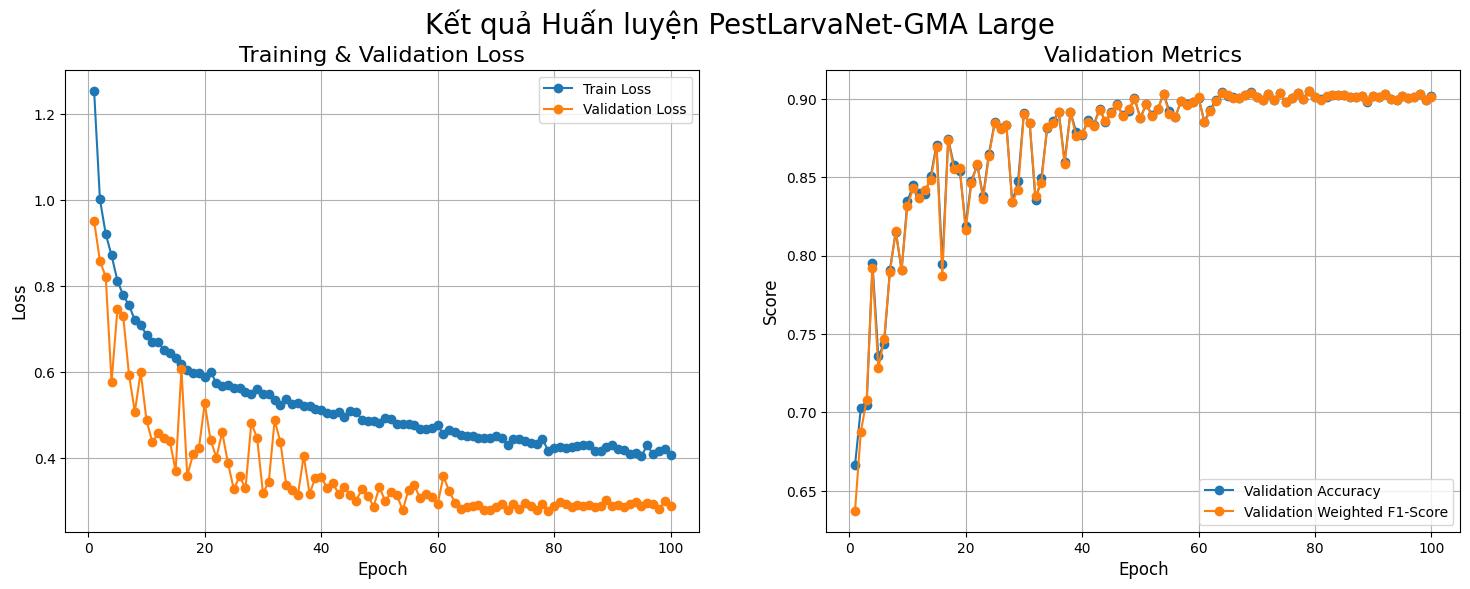


Tải trọng số model tốt nhất để vẽ Confusion Matrix.


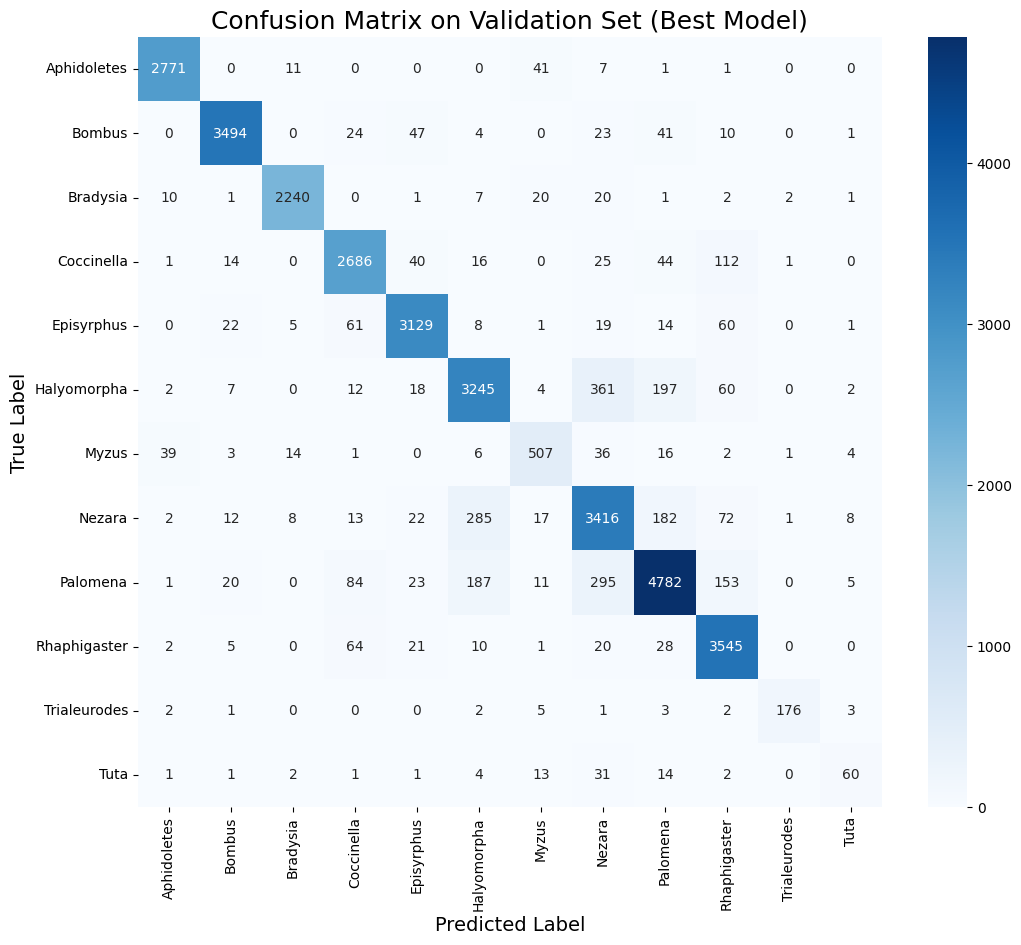

In [16]:
log_df = pd.read_csv(LOG_CSV_PATH)

# --- Vẽ biểu đồ Loss và Accuracy ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax1.plot(log_df['epoch'], log_df['train_loss'], label='Train Loss', marker='o')
ax1.plot(log_df['epoch'], log_df['val_loss'], label='Validation Loss', marker='o')
ax1.set_title('Training & Validation Loss', fontsize=16)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend()
ax1.grid(True)

ax2.plot(log_df['epoch'], log_df['accuracy'], label='Validation Accuracy', marker='o')
ax2.plot(log_df['epoch'], log_df['weighted_f1'], label='Validation Weighted F1-Score', marker='o')
ax2.set_title('Validation Metrics', fontsize=16)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Score', fontsize=12)
ax2.legend()
ax2.grid(True)

plt.suptitle('Kết quả Huấn luyện PestLarvaNet-GMA Large', fontsize=20)
plt.show()

# --- Vẽ Ma trận nhầm lẫn (Confusion Matrix) ---
# Tải lại trọng số của model tốt nhất để đánh giá
best_model_path = os.path.join(CHECKPOINT_DIR, 'best_model.pth')
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print("\nTải trọng số model tốt nhất để vẽ Confusion Matrix.")
    
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        if -1 in labels: continue
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=full_dataset.class_names, 
            yticklabels=full_dataset.class_names)
plt.title('Confusion Matrix on Validation Set (Best Model)', fontsize=18)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()